# 📊 Segmentarea Datelor și Reducerea Dimensionalității
## Unsupervised Learning cu Date Financiare S&P 500

---

### 🎯 Obiectivul Proiectului

În acest proiect vom aplica tehnici de **învățare nesupervizată** pentru:
- 📉 Segmentarea acțiunilor din S&P 500 în grupuri distincte bazate pe comportamentul lor de piață
- 🔍 Reducerea dimensionalității folosind **PCA (Principal Component Analysis)**
- 🎯 Clustering cu **K-Means** și **Clustering Ierarhic**
- 📈 Identificarea numărului optim de clustere folosind **Elbow Method**

---

### 📚 Concepte Cheie Învățate

1. **Unsupervised Learning**: Învățare fără etichete - algoritmul descoperă singur pattern-urile
2. **PCA**: Reducerea dimensionalității păstrând informația esențială
3. **K-Means**: Algoritm de clustering care împarte datele în K grupuri
4. **Clustering Ierarhic**: Creare de dendrograme pentru vizualizarea relațiilor
5. **Standardizare**: Aducerea tuturor features la aceeași scală

---

**Autor**: Sebastian | **Nivel**: Entry-Level Data Science | **Dataset**: S&P 500 Real-Time Data

## 📦 1. Instalarea și Importarea Bibliotecilor

### Ce vom folosi:
- **yfinance**: Pentru descărcarea datelor reale de la S&P 500
- **pandas/numpy**: Manipularea datelor
- **scikit-learn**: Algoritmi de ML (PCA, K-Means, StandardScaler)
- **matplotlib/seaborn**: Vizualizări profesionale
- **scipy**: Clustering ierarhic

In [1]:
# Instalare biblioteci necesare
!pip install yfinance pandas numpy scikit-learn matplotlib seaborn scipy -q

print("✅ Biblioteci instalate cu succes!")

✅ Biblioteci instalate cu succes!


In [2]:
# Importuri generale
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta

# Importuri pentru ML și preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Vizualizări
import matplotlib.pyplot as plt
import seaborn as sns

# Configurare stil vizualizări
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurare afișare
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("✅ Toate bibliotecile au fost importate cu succes!")
print(f"📅 Data de astăzi: {datetime.now().strftime('%Y-%m-%d')}")

✅ Toate bibliotecile au fost importate cu succes!
📅 Data de astăzi: 2025-12-31


## 📥 2. Colectarea Datelor Reale S&P 500

### 🔍 Ce vom face:

Vom descărca date reale pentru **50 de companii importante** din S&P 500, incluzând:
- **Tehnologie**: AAPL, MSFT, GOOGL, META, NVDA, etc.
- **Finance**: JPM, BAC, GS, V, MA
- **Healthcare**: JNJ, UNH, PFE, ABBV
- **Consumer**: WMT, HD, MCD, NKE, SBUX
- **Energie**: XOM, CVX

### 📊 Features calculate:
1. **Returns (Randamente)**: Câștig/pierdere procentuală
2. **Volatilitate**: Cât de mult fluctuează prețul
3. **Volume**: Cât de mult se tranzacționează
4. **Trend**: Direcția generală a prețului
5. **Risk-Adjusted Returns**: Randament raportat la risc

In [3]:
# Lista de 50 companii reprezentative din S&P 500
# Selectate pentru diversitate sectorială
stocks = [
    # Technology
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'TSLA', 'AVGO', 'ORCL', 'CSCO', 'ADBE',
    # Finance
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'V', 'MA', 'AXP', 'BLK', 'SPGI',
    # Healthcare
    'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO', 'MRK', 'ABT', 'DHR', 'LLY', 'BMY',
    # Consumer
    'WMT', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'PG', 'KO', 'PEP',
    # Industrial & Energy
    'XOM', 'CVX', 'BA', 'CAT', 'DE', 'GE', 'UPS', 'HON', 'MMM', 'RTX'
]

print(f"📊 Total companii selectate: {len(stocks)}")
print(f"\n🏢 Companii din sectoare diverse:")
print(f"   - Technology: 10 companii")
print(f"   - Finance: 10 companii")
print(f"   - Healthcare: 10 companii")
print(f"   - Consumer: 10 companii")
print(f"   - Industrial & Energy: 10 companii")

📊 Total companii selectate: 50

🏢 Companii din sectoare diverse:
   - Technology: 10 companii
   - Finance: 10 companii
   - Healthcare: 10 companii
   - Consumer: 10 companii
   - Industrial & Energy: 10 companii


In [4]:
# Descărcarea datelor pentru ultimul an
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print(f"📅 Perioadă analizată: {start_date.strftime('%Y-%m-%d')} până la {end_date.strftime('%Y-%m-%d')}")
print(f"\n⏳ Descărcare date pentru {len(stocks)} companii...\n")

# Descărcare date
data = yf.download(
    stocks,
    start=start_date,
    end=end_date,
    progress=True,
    group_by='ticker'
)

print(f"\n✅ Date descărcate cu succes!")
print(f"📏 Dimensiune dataset: {data.shape}")

📅 Perioadă analizată: 2024-12-31 până la 2025-12-31

⏳ Descărcare date pentru 50 companii...



[*********************100%***********************]  50 of 50 completed



✅ Date descărcate cu succes!
📏 Dimensiune dataset: (250, 250)


## 🔧 3. Feature Engineering - Crearea Caracteristicilor

### 📐 De ce este important Feature Engineering?

**Feature Engineering** este procesul de creare a variabilelor (features) care vor fi folosite de algoritmii de ML. Pentru date financiare, vom calcula:

#### 1️⃣ **Randamente (Returns)**
- Măsoară câștigul/pierderea procentuală
- Formula: `(Preț Final - Preț Inițial) / Preț Inițial * 100`

#### 2️⃣ **Volatilitate (Volatility)**
- Măsoară cât de mult fluctuează prețul
- Se calculează ca deviația standard a randamentelor zilnice
- Volatilitate mare = risc mare, dar și potențial de câștig mare

#### 3️⃣ **Sharpe Ratio (Risk-Adjusted Returns)**
- Măsoară randamentul raportat la risc
- Formula: `Randament Mediu / Volatilitate`
- Valori mai mari = investiție mai bună (randament mai mare per unitate de risc)

#### 4️⃣ **Volum Mediu (Average Volume)**
- Măsoară lichiditatea acțiunii
- Volum mare = ușor de vândut/cumpărat

#### 5️⃣ **Trend (Max Drawdown)**
- Măsoară cea mai mare scădere de la vârf la vale
-Indicat pentru a evalua riscul de pierdere maximă

In [5]:
def calculate_stock_features(stock_symbol, stock_data):
    """
    Calculează features pentru o acțiune.
    
    Parameters:
    -----------
    stock_symbol : str
        Simbolul acțiunii (ex: 'AAPL')
    stock_data : DataFrame
        Date istorice ale acțiunii
    
    Returns:
    --------
    dict : Dicționar cu features calculate
    """
    try:
        # Extragem datele de închidere și volum
        close_prices = stock_data['Close'].dropna()
        volumes = stock_data['Volume'].dropna()
        
        # 1. Calcul Randamente (Returns)
        total_return = ((close_prices.iloc[-1] - close_prices.iloc[0]) / close_prices.iloc[0]) * 100
        
        # 2. Calcul Volatilitate (Standard Deviation of Daily Returns)
        daily_returns = close_prices.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252) * 100  # Anualizată
        
        # 3. Sharpe Ratio (Risk-Adjusted Returns)
        # Presupunem risk-free rate = 2% anual
        avg_daily_return = daily_returns.mean() * 252 * 100  # Anualizat
        sharpe_ratio = (avg_daily_return - 2) / volatility if volatility > 0 else 0
        
        # 4. Volum Mediu
        avg_volume = volumes.mean()
        
        # 5. Max Drawdown (Cea mai mare scădere de la vârf)
        cumulative = (1 + daily_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = ((cumulative - running_max) / running_max) * 100
        max_drawdown = drawdown.min()
        
        # 6. Trend (Slope of price trend)
        x = np.arange(len(close_prices))
        z = np.polyfit(x, close_prices, 1)
        trend_slope = z[0]
        
        return {
            'Symbol': stock_symbol,
            'Total_Return_%': total_return,
            'Volatility_%': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Avg_Volume_Millions': avg_volume / 1_000_000,
            'Max_Drawdown_%': max_drawdown,
            'Trend_Slope': trend_slope
        }
    except Exception as e:
        print(f"❌ Eroare la {stock_symbol}: {e}")
        return None

# Calculăm features pentru toate acțiunile
print("🔧 Calculare features pentru fiecare acțiune...\n")
features_list = []

for stock in stocks:
    try:
        stock_data = data[stock]
        features = calculate_stock_features(stock, stock_data)
        if features:
            features_list.append(features)
            print(f"✅ {stock}: Features calculate")
    except:
        print(f"⚠️ {stock}: Date insuficiente")
        continue

# Creăm DataFrame cu toate features
df_features = pd.DataFrame(features_list)
df_features = df_features.dropna()

print(f"\n✅ Features create cu succes pentru {len(df_features)} companii!")
print(f"\n📊 Preview dataset:")
df_features.head(10)

🔧 Calculare features pentru fiecare acțiune...

✅ AAPL: Features calculate
✅ MSFT: Features calculate
✅ GOOGL: Features calculate
✅ META: Features calculate
✅ NVDA: Features calculate
✅ TSLA: Features calculate
✅ AVGO: Features calculate
✅ ORCL: Features calculate
✅ CSCO: Features calculate
✅ ADBE: Features calculate
✅ JPM: Features calculate
✅ BAC: Features calculate
✅ WFC: Features calculate
✅ GS: Features calculate
✅ MS: Features calculate
✅ V: Features calculate
✅ MA: Features calculate
✅ AXP: Features calculate
✅ BLK: Features calculate
✅ SPGI: Features calculate
✅ JNJ: Features calculate
✅ UNH: Features calculate
✅ PFE: Features calculate
✅ ABBV: Features calculate
✅ TMO: Features calculate
✅ MRK: Features calculate
✅ ABT: Features calculate
✅ DHR: Features calculate
✅ LLY: Features calculate
✅ BMY: Features calculate
✅ WMT: Features calculate
✅ HD: Features calculate
✅ MCD: Features calculate
✅ NKE: Features calculate
✅ SBUX: Features calculate
✅ TGT: Features calculate
✅ LOW: F

,Symbol,Total_Return_%,Volatility_%,Sharpe_Ratio,Avg_Volume_Millions,Max_Drawdown_%,Trend_Slope
0,AAPL,12.3080,32.4608,0.4599,54.1035,-30.2226,0.2274
1,MSFT,16.8526,24.2877,0.6863,22.1514,-20.5566,0.5511
2,GOOGL,66.1950,32.4092,1.6868,36.2182,-29.8059,0.5900
3,META,10.8651,38.0197,0.4097,15.4772,-34.1508,0.3353
4,NVDA,36.5315,49.6337,0.8434,220.5238,-36.8810,0.3506
5,TSLA,19.8936,63.2964,0.5717,97.6110,-48.1902,0.5928
6,AVGO,51.4163,53.1594,1.0179,26.6849,-40.0357,0.8418
7,ORCL,19.5810,61.8072,0.5496,17.4009,-45.5518,0.4832
8,CSCO,34.2724,23.7793,1.2890,20.9268,-17.4578,0.0796
9,ADBE,-20.5147,30.6675,-0.6665,3.9453,-32.6884,-0.4336


📈 STATISTICI DESCRIPTIVE

       Total_Return_%  Volatility_%  Sharpe_Ratio  Avg_Volume_Millions  \
count         50.0000       50.0000       50.0000              50.0000   
mean          18.1200       30.7500        0.5900              17.6700   
std           24.8500       10.0200        0.7000              33.8400   
min          -32.7100       17.5300       -0.7600               0.7000   
25%            0.5800       24.1800        0.0900               3.9500   
50%           13.1100       29.0000        0.5600               8.2000   
75%           33.8600       32.6300        0.9900              16.4900   
max           85.6100       63.3000        2.1500             220.5200   

       Max_Drawdown_%  Trend_Slope  
count         50.0000      50.0000  
mean         -26.2100       0.2000  
std           10.0600       0.3700  
min          -60.0600      -0.9000  
25%          -32.2600       0.0200  
50%          -24.5800       0.0800  
75%          -18.9400       0.3500  
max        

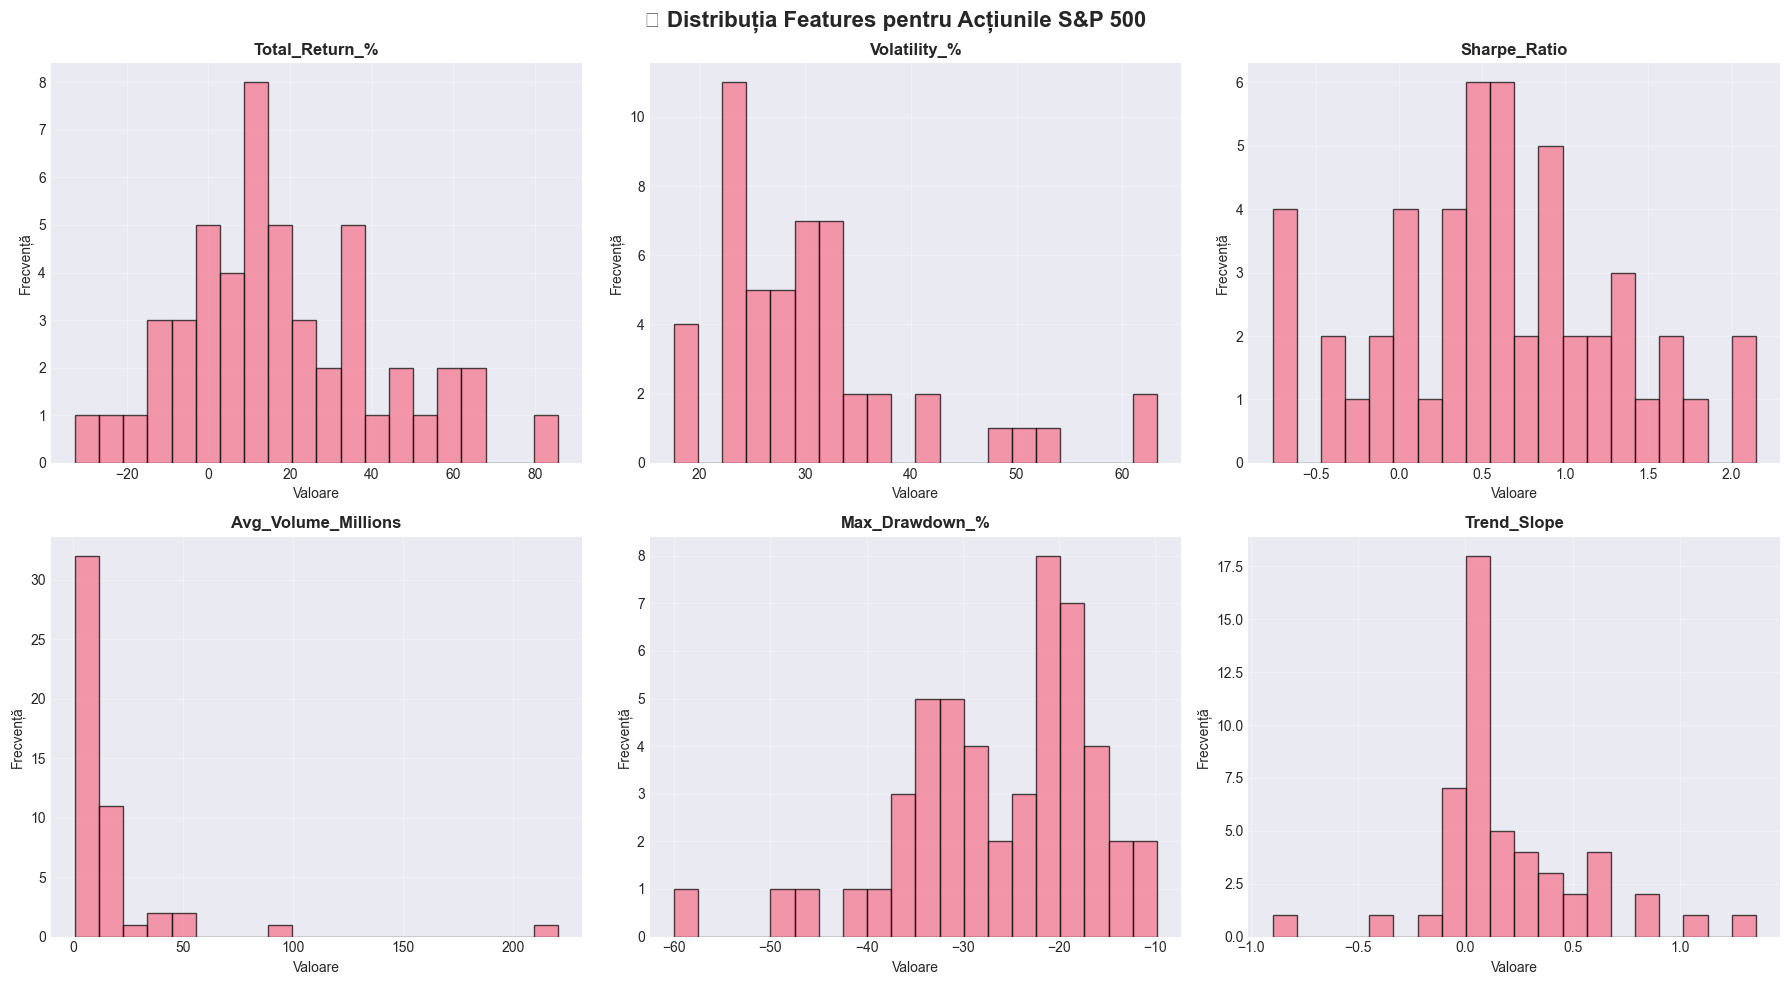


💡 Observații:
   - Randament mediu: 18.12%
   - Volatilitate medie: 30.75%
   - Sharpe Ratio mediu: 0.59


In [6]:
# Statistici descriptive
print("📈 STATISTICI DESCRIPTIVE\n")
print("="*70)
print(df_features.describe().round(2))
print("="*70)

# Vizualizare distribuție features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Distribuția Features pentru Acțiunile S&P 500', fontsize=16, fontweight='bold')

features_to_plot = ['Total_Return_%', 'Volatility_%', 'Sharpe_Ratio', 
                    'Avg_Volume_Millions', 'Max_Drawdown_%', 'Trend_Slope']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df_features[feature], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel('Valoare')
    ax.set_ylabel('Frecvență')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observații:")
print(f"   - Randament mediu: {df_features['Total_Return_%'].mean():.2f}%")
print(f"   - Volatilitate medie: {df_features['Volatility_%'].mean():.2f}%")
print(f"   - Sharpe Ratio mediu: {df_features['Sharpe_Ratio'].mean():.2f}")

## 🔄 4. Standardizarea Datelor (Feature Scaling)

### ❓ De ce este necesară standardizarea?

**Problemă**: Features-urile noastre au scale diferite:
- `Sharpe_Ratio` este între -1 și 3
- `Avg_Volume_Millions` poate fi între 1 și 100+
- `Total_Return_%` poate fi între -50% și +200%

**Impact**: Algoritmii de clustering (K-Means, Ierarhic) și PCA sunt **sensibili la scară**:
- Features cu valori mari vor domina distanțele
- Features cu valori mici vor fi ignorate

### 🎯 Soluția: StandardScaler

**StandardScaler** transformă fiecare feature astfel încât:
- **Media** devine 0
- **Deviația standard** devine 1

Formula: `z = (x - μ) / σ`

unde:
- `x` = valoarea originală
- `μ` = media
- `σ` = deviația standard

**Rezultat**: Toate features vor fi pe aceeași scală, permițând comparații corecte!

In [7]:
# Separăm features de simboluri
X = df_features.drop('Symbol', axis=1)
symbols = df_features['Symbol'].values

print("📊 Date originale (primele 5 rânduri):")
print("="*70)
print(X.head())
print("="*70)

# Aplicăm StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertim înapoi în DataFrame pentru vizualizare
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n🔄 Date standardizate (primele 5 rânduri):")
print("="*70)
print(X_scaled_df.head())
print("="*70)

# Verificăm că standardizarea a funcționat
print("\n✅ Verificare standardizare:")
print(f"   Media după standardizare: {X_scaled_df.mean().round(10).tolist()}")
print(f"   Std după standardizare: {X_scaled_df.std().round(2).tolist()}")
print("\n💡 Media ≈ 0 și Std ≈ 1 confirmă că standardizarea a funcționat!")

📊 Date originale (primele 5 rânduri):
   Total_Return_%  Volatility_%  Sharpe_Ratio  Avg_Volume_Millions  \
0         12.3080       32.4608        0.4599              54.1035   
1         16.8526       24.2877        0.6863              22.1514   
2         66.1950       32.4092        1.6868              36.2182   
3         10.8651       38.0197        0.4097              15.4772   
4         36.5315       49.6337        0.8434             220.5238   

   Max_Drawdown_%  Trend_Slope  
0        -30.2226       0.2274  
1        -20.5566       0.5511  
2        -29.8059       0.5900  
3        -34.1508       0.3353  
4        -36.8810       0.3506  

🔄 Date standardizate (primele 5 rânduri):
   Total_Return_%  Volatility_%  Sharpe_Ratio  Avg_Volume_Millions  \
0         -0.2364        0.1729       -0.1886               1.0875   
1         -0.0516       -0.6508        0.1381               0.1338   
2          1.9542        0.1677        1.5821               0.5537   
3         -0.2950   

## 🔍 5. Reducerea Dimensionalității cu PCA

### 📚 Ce este PCA (Principal Component Analysis)?

**PCA** este o tehnică de reducere a dimensionalității care:
- Transformă features originale în **componente principale**
- Componentele sunt **necorelate** între ele
- Prima componentă explică **cea mai mare varianță** din date
- A doua componentă explică **a doua cea mai mare varianță**, etc.

### 🎯 De ce folosim PCA?

1. **Reducerea dimensionalității**: De la 6 features la 2-3 componente
2. **Vizualizare**: Putem plota datele în 2D/3D
3. **Eliminarea redundanței**: Combinăm features corelate
4. **Îmbunătățirea performanței**: Reducerea noise-ului

### 📊 Cum funcționează?

1. Standardizăm datele (✅ deja făcut)
2. Calculăm matricea de covarianță
3. Găsim vectorii proprii (eigenvectors) și valorile proprii (eigenvalues)
4. Selectăm top K componente care explică cea mai mare varianță

### 📈 Interpretare

- **Explained Variance**: Cât la sută din varianța totală explică fiecare componentă
- **Cumulative Variance**: Suma cumulată a varianței explicate

📊 ANALIZA COMPONENTELOR PRINCIPALE

Componentă      Varianță Explicată   Varianță Cumulată   
PC1                           43.45%              43.45%
PC2                           35.72%              79.17%
PC3                           12.84%              92.01%
PC4                            5.87%              97.88%
PC5                            1.70%              99.58%
PC6                            0.42%             100.00%


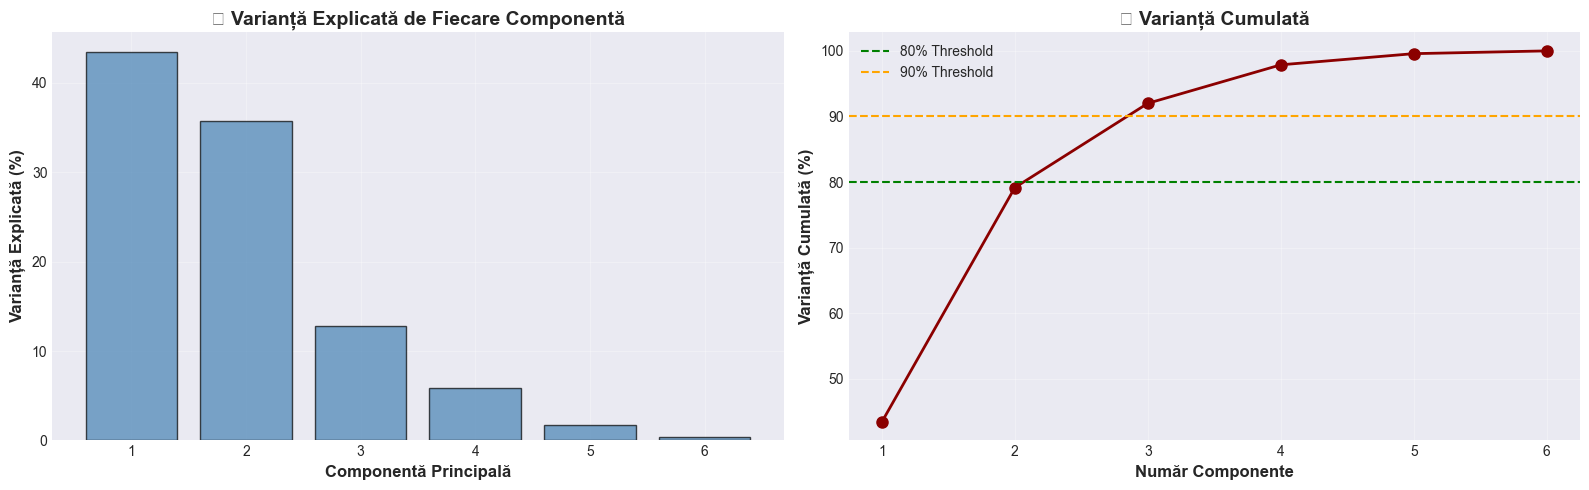


💡 Interpretare:
   - Primele 2 componente explică 79.17% din varianță
   - Primele 3 componente explică 92.01% din varianță
   - Pentru clustering, vom folosi primele 2-3 componente


In [8]:
# Aplicăm PCA pentru toate componentele (pentru a vedea varianța explicată)
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculăm varianța explicată
explained_variance = pca_full.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

print("📊 ANALIZA COMPONENTELOR PRINCIPALE\n")
print("="*70)
print(f"{'Componentă':<15} {'Varianță Explicată':<20} {'Varianță Cumulată':<20}")
print("="*70)
for i, (exp_var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1:<14} {exp_var:>18.2f}% {cum_var:>18.2f}%")
print("="*70)

# Vizualizare varianță explicată
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Grafic 1: Varianță explicată per componentă
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, 
        alpha=0.7, edgecolor='black', color='steelblue')
ax1.set_xlabel('Componentă Principală', fontsize=12, fontweight='bold')
ax1.set_ylabel('Varianță Explicată (%)', fontsize=12, fontweight='bold')
ax1.set_title('📊 Varianță Explicată de Fiecare Componentă', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.grid(True, alpha=0.3)

# Grafic 2: Varianță cumulată
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         marker='o', linewidth=2, markersize=8, color='darkred')
ax2.axhline(y=80, color='green', linestyle='--', label='80% Threshold')
ax2.axhline(y=90, color='orange', linestyle='--', label='90% Threshold')
ax2.set_xlabel('Număr Componente', fontsize=12, fontweight='bold')
ax2.set_ylabel('Varianță Cumulată (%)', fontsize=12, fontweight='bold')
ax2.set_title('📈 Varianță Cumulată', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretare:")
print(f"   - Primele 2 componente explică {cumulative_variance[1]:.2f}% din varianță")
print(f"   - Primele 3 componente explică {cumulative_variance[2]:.2f}% din varianță")
print(f"   - Pentru clustering, vom folosi primele 2-3 componente")

📊 ANALIZĂ LOADINGS (Contribuția Features la Componente)

                       PC1     PC2
Total_Return_%      0.6040 -0.0370
Volatility_%        0.0640  0.6500
Sharpe_Ratio        0.5850 -0.1090
Avg_Volume_Millions 0.1070  0.4080
Max_Drawdown_%      0.0850 -0.6220
Trend_Slope         0.5190  0.1020

💡 Interpretare Loadings:
   - Valori pozitive mari: feature contribuie pozitiv la componentă
   - Valori negative mari: feature contribuie negativ la componentă
   - Valori aproape de 0: feature nu influențează componenta


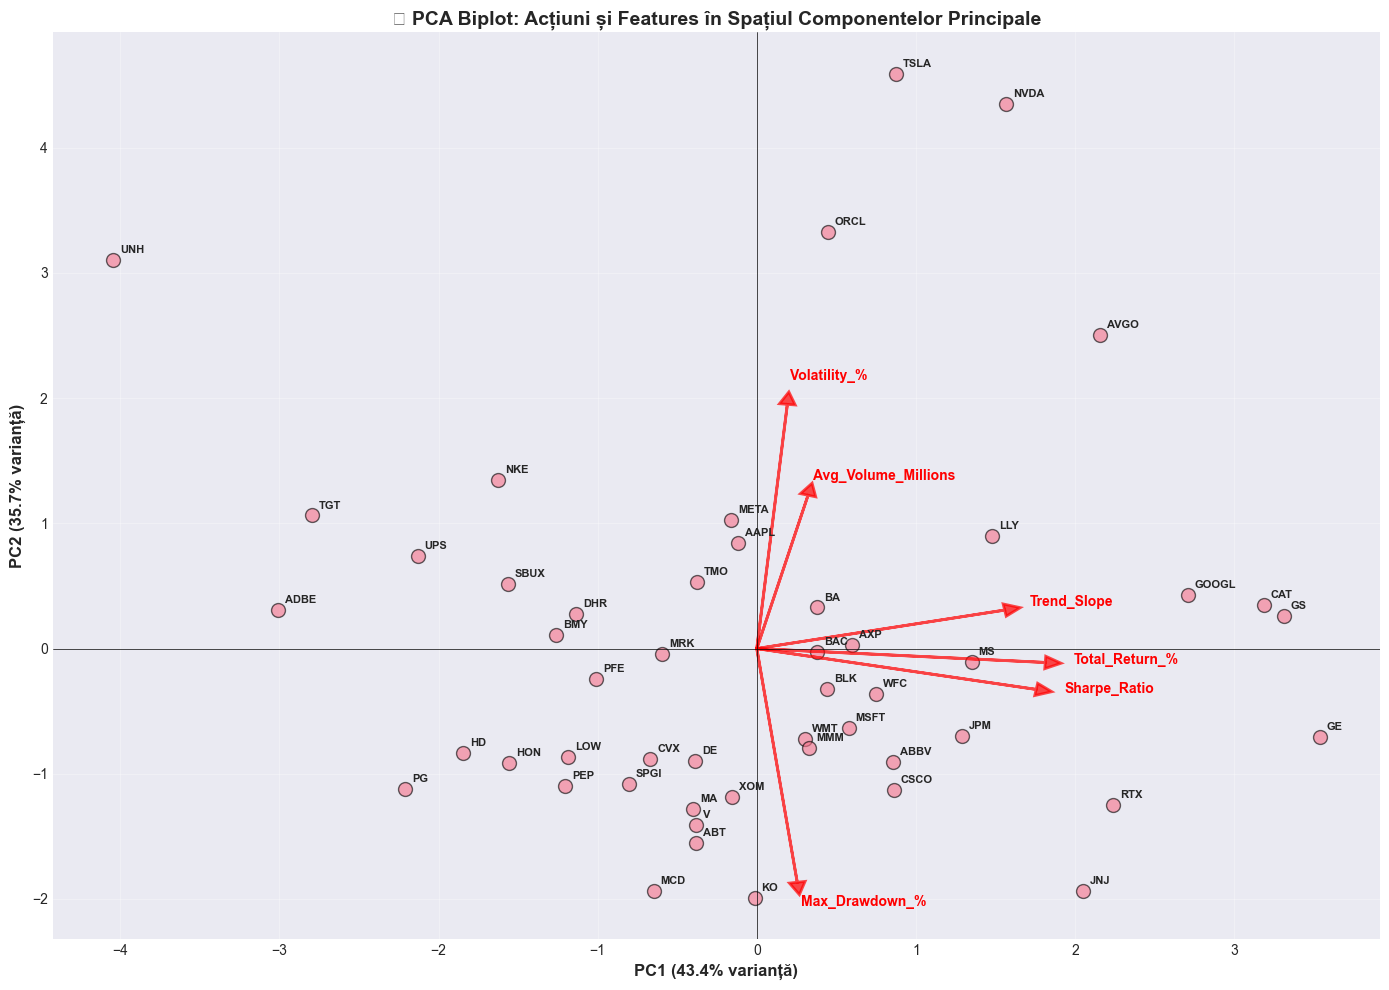


🎯 Interpretare Biplot:
   - Săgețile roșii = direcția și intensitatea fiecărui feature
   - Acțiunile apropiate = comportament similar de piață
   - Acțiunile în direcția unei săgeți = valori mari pentru acel feature


In [9]:
# Aplicăm PCA cu 2 componente pentru vizualizare
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Creăm DataFrame cu rezultatele
df_pca = pd.DataFrame(
    X_pca_2d,
    columns=['PC1', 'PC2']
)
df_pca['Symbol'] = symbols

print("📊 ANALIZĂ LOADINGS (Contribuția Features la Componente)\n")
print("="*70)

# Loadings = cât de mult contribuie fiecare feature la fiecare componentă
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)

print(loadings.round(3))
print("="*70)

print("\n💡 Interpretare Loadings:")
print("   - Valori pozitive mari: feature contribuie pozitiv la componentă")
print("   - Valori negative mari: feature contribuie negativ la componentă")
print("   - Valori aproape de 0: feature nu influențează componenta")

# Vizualizare Biplot
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot pentru acțiuni
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], 
                    s=100, alpha=0.6, edgecolors='black', linewidth=1)

# Adăugăm etichete pentru fiecare acțiune
for idx, row in df_pca.iterrows():
    ax.annotate(row['Symbol'], 
               (row['PC1'], row['PC2']),
               fontsize=8, fontweight='bold',
               xytext=(5, 5), textcoords='offset points')

# Adăugăm săgeți pentru features (loadings)
scale_factor = 3
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, 
            loadings.loc[feature, 'PC1'] * scale_factor,
            loadings.loc[feature, 'PC2'] * scale_factor,
            head_width=0.1, head_length=0.1, 
            fc='red', ec='red', linewidth=2, alpha=0.7)
    ax.text(loadings.loc[feature, 'PC1'] * scale_factor * 1.1,
           loadings.loc[feature, 'PC2'] * scale_factor * 1.1,
           feature, fontsize=10, fontweight='bold', color='red')

ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_title('🎯 PCA Biplot: Acțiuni și Features în Spațiul Componentelor Principale', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n🎯 Interpretare Biplot:")
print("   - Săgețile roșii = direcția și intensitatea fiecărui feature")
print("   - Acțiunile apropiate = comportament similar de piață")
print("   - Acțiunile în direcția unei săgeți = valori mari pentru acel feature")

## 📐 6. Alegerea Numărului Optim de Clustere - Elbow Method

### ❓ De ce trebuie să alegem numărul de clustere?

Algoritmul K-Means necesită să specificăm **K** (numărul de clustere) înainte de a rula. Dar cum știm câte clustere sunt optime?

### 🎯 Metoda Cotului (Elbow Method)

**Principiu**: Măsurăm calitatea clustering-ului pentru diferite valori de K.

**Metrici folosite**:

1. **Inertia (WCSS - Within-Cluster Sum of Squares)**
   - Măsoară cât de compacte sunt clusterele
   - Suma distanțelor pătratice între puncte și centroidul lor
   - **Valori mai mici = clustere mai compacte** ✅
   - Formula: `Σ(distanță până la centroid)²`

2. **Silhouette Score**
   - Măsoară cât de bine sunt separate clusterele
   - Valori între -1 și 1
   - **Valori aproape de 1 = clustere bine separate** ✅
   - **Valori aproape de 0 = clustere care se suprapun** ⚠️
   - **Valori negative = puncte în clustere greșite** ❌

3. **Davies-Bouldin Index**
   - Raportul dintre dispersia intra-cluster și separarea inter-cluster
   - **Valori mai mici = clustere mai bune** ✅
   - Valori tipice: 0.5 - 2.0

### 📊 Cum identificăm "cotul"?

Căutăm punctul unde:
- Inertia începe să scadă mai încet
- Silhouette Score este maxim
- Davies-Bouldin Index este minim

Acel punct = **numărul optim de clustere** 🎯

🔍 Testare număr optim de clustere...

K     Inertia         Silhouette      Davies-Bouldin 
2     151.22          0.421           1.116          
3     97.14           0.378           0.818          
4     64.09           0.380           0.796          
5     44.97           0.410           0.746          
6     35.89           0.406           0.729          
7     30.54           0.389           0.625          
8     24.51           0.427           0.581          
9     19.59           0.433           0.559          
10    16.15           0.414           0.630          


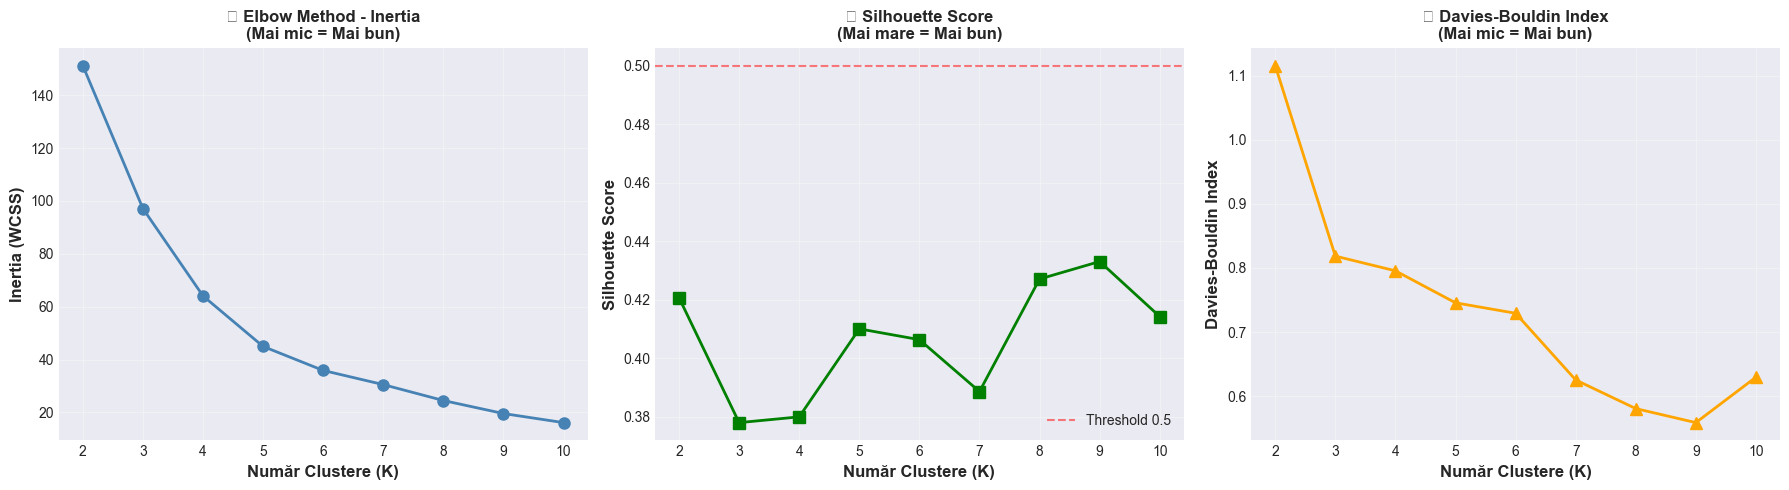


🎯 RECOMANDĂRI:
   - K optim bazat pe Silhouette Score: 9
   - K optim bazat pe Davies-Bouldin: 9
   - Pentru acest proiect, vom folosi K = 9


In [10]:
# Testăm diferite valori de K
K_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("🔍 Testare număr optim de clustere...\n")
print("="*70)
print(f"{'K':<5} {'Inertia':<15} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("="*70)

for k in K_range:
    # Aplicăm K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca_2d)
    
    # Calculăm metrici
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_pca_2d, labels)
    davies_bouldin = davies_bouldin_score(X_pca_2d, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"{k:<5} {inertia:<15.2f} {silhouette:<15.3f} {davies_bouldin:<15.3f}")

print("="*70)

# Vizualizare metrici
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafic 1: Inertia (Elbow Curve)
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Număr Clustere (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12, fontweight='bold')
axes[0].set_title('📉 Elbow Method - Inertia\n(Mai mic = Mai bun)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# Grafic 2: Silhouette Score
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Număr Clustere (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('📊 Silhouette Score\n(Mai mare = Mai bun)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold 0.5')
axes[1].legend()

# Grafic 3: Davies-Bouldin Index
axes[2].plot(K_range, davies_bouldin_scores, marker='^', linewidth=2, markersize=8, color='orange')
axes[2].set_xlabel('Număr Clustere (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[2].set_title('📈 Davies-Bouldin Index\n(Mai mic = Mai bun)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Determinăm K optim
best_k_silhouette = K_range[np.argmax(silhouette_scores)]
best_k_davies = K_range[np.argmin(davies_bouldin_scores)]

print(f"\n🎯 RECOMANDĂRI:")
print(f"   - K optim bazat pe Silhouette Score: {best_k_silhouette}")
print(f"   - K optim bazat pe Davies-Bouldin: {best_k_davies}")
print(f"   - Pentru acest proiect, vom folosi K = {best_k_silhouette}")

## 🎯 7. K-Means Clustering

### 📚 Ce este K-Means?

**K-Means** este unul dintre cei mai populari algoritmi de clustering. Funcționează astfel:

### 🔄 Algoritmul K-Means - Pas cu Pas:

1. **Inițializare**: Alege aleatoriu K centroizi (puncte centrale)
2. **Assignment**: Atribuie fiecare punct la cel mai apropiat centroid
3. **Update**: Recalculează centroizii ca medie a punctelor din cluster
4. **Repeat**: Repetă pașii 2-3 până când centroizii nu se mai mișcă

### 📊 Caracteristici:

**Avantaje** ✅:
- Simplu și rapid
- Scalabil la date mari
- Funcționează bine când clusterele sunt sferice și de dimensiuni similare

**Dezavantaje** ⚠️:
- Trebuie să specificăm K în avans
- Sensibil la valori extreme (outliers)
- Poate converge la minime locale
- Presupune clustere sferice

### 🎯 Aplicarea la Date Financiare:

Vom grupa acțiunile S&P 500 în clustere bazate pe:
- Randamente
- Volatilitate
- Sharpe Ratio
- Volum
- Max Drawdown
- Trend

**Rezultat așteptat**: Identificarea de grupuri precum:
- 📈 Tech stocks cu creștere mare și volatilitate mare
- 💰 Acțiuni stabile cu dividende (blue chips)
- ⚠️ Acțiuni volatile cu randamente mixte

🎯 Aplicare K-Means cu K = 9 clustere

✅ K-Means aplicat cu succes!

📊 METRICI DE PERFORMANȚĂ:
   - Inertia: 19.59
   - Silhouette Score: 0.433 (Optimal: >0.5)
   - Davies-Bouldin Index: 0.559 (Optimal: <1.0)
   - Număr iterații până la convergență: 3

📊 DISTRIBUȚIA ACȚIUNILOR ÎN CLUSTERE:

   Cluster 0: 4 acțiuni (8.0%)
   Cluster 1: 8 acțiuni (16.0%)
   Cluster 2: 13 acțiuni (26.0%)
   Cluster 3: 9 acțiuni (18.0%)
   Cluster 4: 4 acțiuni (8.0%)
   Cluster 5: 4 acțiuni (8.0%)
   Cluster 6: 1 acțiuni (2.0%)
   Cluster 7: 2 acțiuni (4.0%)
   Cluster 8: 5 acțiuni (10.0%)


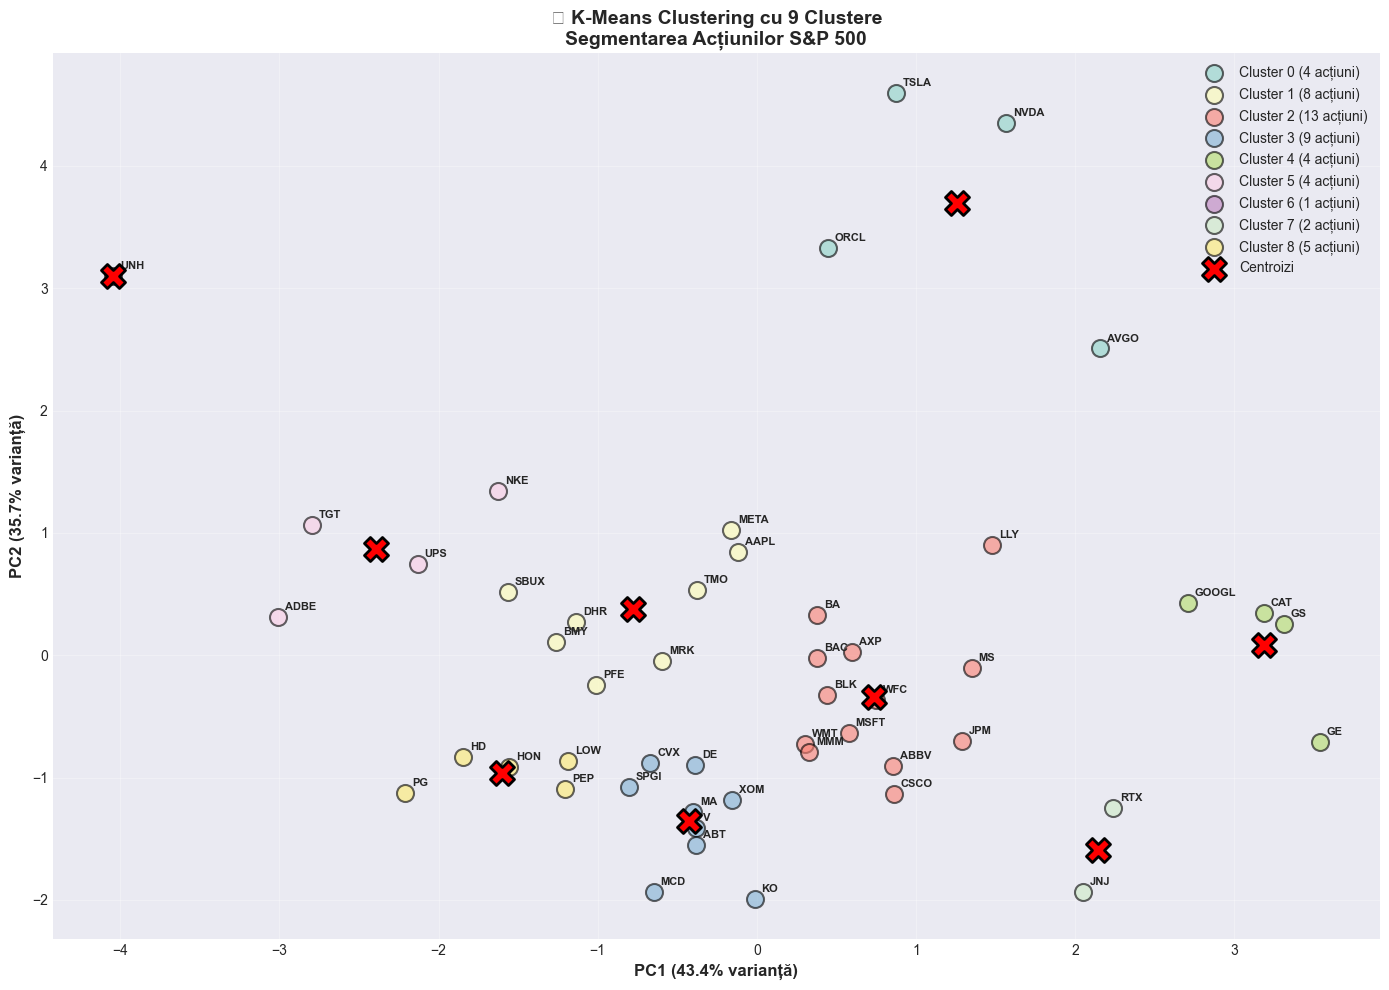

In [11]:
# Aplicăm K-Means cu numărul optim de clustere
optimal_k = best_k_silhouette

print(f"🎯 Aplicare K-Means cu K = {optimal_k} clustere\n")

# Inițializare și antrenare K-Means
kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    max_iter=300
)

# Predict clusters
df_pca['Cluster_KMeans'] = kmeans.fit_predict(X_pca_2d)
df_features['Cluster_KMeans'] = kmeans.labels_

# Calculăm metrici finale
final_silhouette = silhouette_score(X_pca_2d, kmeans.labels_)
final_davies_bouldin = davies_bouldin_score(X_pca_2d, kmeans.labels_)

print("✅ K-Means aplicat cu succes!\n")
print("="*70)
print(f"📊 METRICI DE PERFORMANȚĂ:")
print("="*70)
print(f"   - Inertia: {kmeans.inertia_:.2f}")
print(f"   - Silhouette Score: {final_silhouette:.3f} (Optimal: >0.5)")
print(f"   - Davies-Bouldin Index: {final_davies_bouldin:.3f} (Optimal: <1.0)")
print(f"   - Număr iterații până la convergență: {kmeans.n_iter_}")
print("="*70)

# Distribuția clusterelor
print(f"\n📊 DISTRIBUȚIA ACȚIUNILOR ÎN CLUSTERE:\n")
cluster_counts = df_pca['Cluster_KMeans'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"   Cluster {cluster_id}: {count} acțiuni ({count/len(df_pca)*100:.1f}%)")

# Vizualizare clustere
fig, ax = plt.subplots(figsize=(14, 10))

# Plot pentru fiecare cluster
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_data = df_pca[df_pca['Cluster_KMeans'] == i]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], 
              s=150, alpha=0.6, c=[colors[i]], 
              edgecolors='black', linewidth=1.5,
              label=f'Cluster {i} ({len(cluster_data)} acțiuni)')
    
    # Adăugăm etichete
    for idx, row in cluster_data.iterrows():
        ax.annotate(row['Symbol'], 
                   (row['PC1'], row['PC2']),
                   fontsize=8, fontweight='bold',
                   xytext=(5, 5), textcoords='offset points')

# Plot centroizi
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], 
          s=300, c='red', marker='X', 
          edgecolors='black', linewidth=2,
          label='Centroizi', zorder=5)

ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_title(f'🎯 K-Means Clustering cu {optimal_k} Clustere\nSegmentarea Acțiunilor S&P 500', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 ANALIZA CARACTERISTICILOR CLUSTERELOR


🎯 CLUSTER 0

📈 Statistici Medii:
   - Randament Mediu: 31.86%
   - Volatilitate Medie: 56.97%
   - Sharpe Ratio Mediu: 0.746
   - Volum Mediu: 90.56M
   - Max Drawdown Mediu: -42.66%

🏢 Acțiuni în Cluster (4 total):
   NVDA, TSLA, AVGO, ORCL

🎯 CLUSTER 1

📈 Statistici Medii:
   - Randament Mediu: 5.14%
   - Volatilitate Medie: 31.91%
   - Sharpe Ratio Mediu: 0.244
   - Volum Mediu: 20.70M
   - Max Drawdown Mediu: -29.72%

🏢 Acțiuni în Cluster (8 total):
   AAPL, META, PFE, TMO, MRK, DHR, BMY, SBUX

🎯 CLUSTER 2

📈 Statistici Medii:
   - Randament Mediu: 29.48%
   - Volatilitate Medie: 29.03%
   - Sharpe Ratio Mediu: 0.979
   - Volum Mediu: 12.20M
   - Max Drawdown Mediu: -24.39%

🏢 Acțiuni în Cluster (13 total):
   MSFT, CSCO, JPM, BAC, WFC, MS, AXP, BLK, ABBV, LLY
   WMT, BA, MMM

🎯 CLUSTER 3

📈 Statistici Medii:
   - Randament Mediu: 11.63%
   - Volatilitate Medie: 22.53%
   - Sharpe Ratio Mediu: 0.525
   - Volum Mediu: 7.03M
   - Max Drawdown

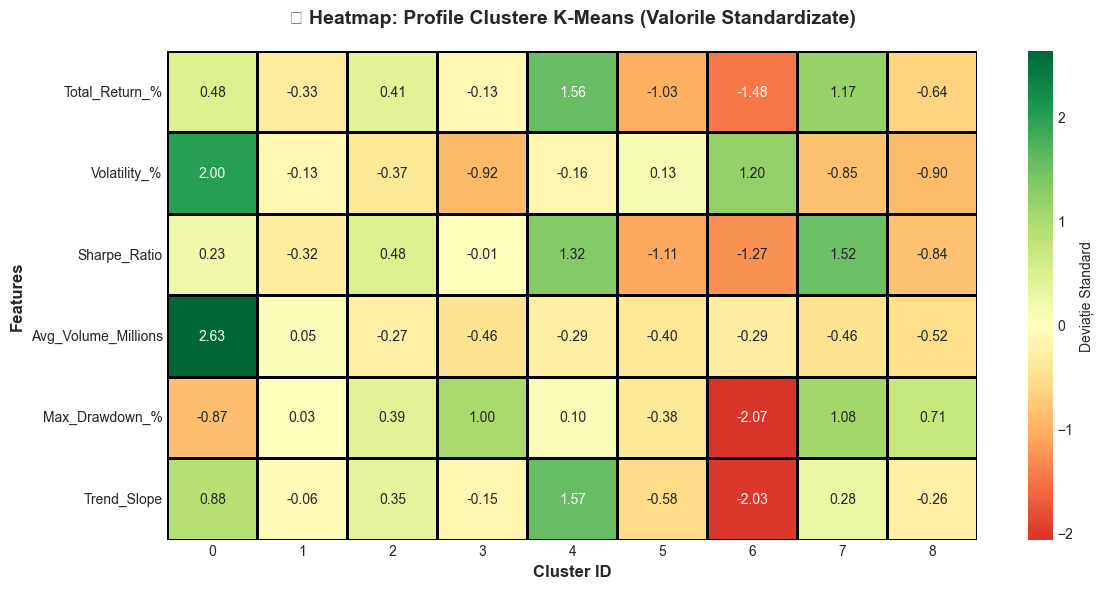


💡 Interpretare Heatmap:
   - Verde: Valori peste medie pentru acel feature
   - Roșu: Valori sub medie pentru acel feature
   - Galben: Valori apropiate de medie


In [13]:
# Analiza caracteristicilor fiecărui cluster
print("📊 ANALIZA CARACTERISTICILOR CLUSTERELOR\n")
print("="*90)

for cluster_id in range(optimal_k):
    print(f"\n🎯 CLUSTER {cluster_id}")
    print("="*90)
    
    # Selectăm acțiunile din cluster
    cluster_stocks = df_features[df_features['Cluster_KMeans'] == cluster_id]
    
    # Calculăm statistici medii
    print(f"\n📈 Statistici Medii:")
    print(f"   - Randament Mediu: {cluster_stocks['Total_Return_%'].mean():.2f}%")
    print(f"   - Volatilitate Medie: {cluster_stocks['Volatility_%'].mean():.2f}%")
    print(f"   - Sharpe Ratio Mediu: {cluster_stocks['Sharpe_Ratio'].mean():.3f}")
    print(f"   - Volum Mediu: {cluster_stocks['Avg_Volume_Millions'].mean():.2f}M")
    print(f"   - Max Drawdown Mediu: {cluster_stocks['Max_Drawdown_%'].mean():.2f}%")
    
    # Listăm acțiunile
    print(f"\n🏢 Acțiuni în Cluster ({len(cluster_stocks)} total):")
    symbols_list = cluster_stocks['Symbol'].tolist()
    for i in range(0, len(symbols_list), 10):
        print(f"   {', '.join(symbols_list[i:i+10])}")
    
    print("="*90)

# Heatmap caracteristici medii per cluster
cluster_profiles = df_features.groupby('Cluster_KMeans').mean(numeric_only=True)
cluster_profiles = cluster_profiles.drop('Symbol', axis=1, errors='ignore')

# Standardizăm pentru vizualizare
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_normalized.T, 
            annot=True, fmt='.2f', 
            cmap='RdYlGn', center=0,
            linewidths=1, linecolor='black',
            cbar_kws={'label': 'Deviație Standard'})
plt.title('🔥 Heatmap: Profile Clustere K-Means (Valorile Standardizate)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster ID', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretare Heatmap:")
print("   - Verde: Valori peste medie pentru acel feature")
print("   - Roșu: Valori sub medie pentru acel feature")
print("   - Galben: Valori apropiate de medie")

## 🌳 8. Clustering Ierarhic (Hierarchical Clustering)

### 📚 Ce este Clustering Ierarhic?

**Clustering Ierarhic** este o metodă alternativă de clustering care creează o ierarhie de clustere, spre deosebire de K-Means care creează un număr fix de clustere.

### 🔄 Două Abordări:

#### 1️⃣ **Agglomerative (Bottom-Up)** - cea pe care o vom folosi
- Start: Fiecare punct = un cluster separat
- Pas 1: Găsește cele mai apropiate 2 clustere și le combină
- Pas 2: Repetă până când toate punctele sunt într-un singur cluster
- Rezultat: Dendrogramă (arbore ierarhic)

#### 2️⃣ **Divisive (Top-Down)**
- Start: Toate punctele într-un singur cluster
- Divide treptat clusterul în sub-clustere

### 📏 Metode de Legare (Linkage Methods):

Cum măsurăm distanța între clustere?

1. **Single Linkage**: Distanța minimă între orice două puncte din clustere
   - Avantaj: Detectează forme neregulate
   - Dezavantaj: Sensibil la outliers

2. **Complete Linkage**: Distanța maximă între orice două puncte
   - Avantaj: Clustere compacte
   - Dezavantaj: Sensibil la outliers

3. **Average Linkage**: Media distanțelor între toate perechile
   - Compromis între single și complete

4. **Ward**: Minimizează varianța totală intra-cluster
   - **Cel mai recomandat** pentru clustere compacte ✅
   - Similar cu K-Means în filosofie

### 🌲 Dendrograma:

Vizualizarea rezultatului:
- **Axă Y**: Distanța la care clusterele s-au combinat
- **Axă X**: Punctele de date (acțiunile)
- **Interpretare**: Tăiem dendrograma la o anumită înălțime pentru a obține K clustere

### ⚖️ K-Means vs. Clustering Ierarhic:

| Caracteristică | K-Means | Ierarhic |
|----------------|---------|----------|
| Număr clustere | Trebuie specificat | Poate fi determinat vizual |
| Complexitate | O(n) rapid | O(n²) sau O(n³) lent |
| Forma clusterelor | Sferice | Orice formă |
| Determinism | Nu (aleatoriu) | Da (reproducibil) |
| Vizualizare | Scatter plot | Dendrogramă |
| Scalabilitate | Excelentă | Limitată |

🌳 Aplicare Clustering Ierarhic (Agglomerative cu Ward Linkage)

✅ Linkage matrix calculată!
   - Metodă: Ward (minimizează varianța intra-cluster)
   - Număr de merge-uri: 49


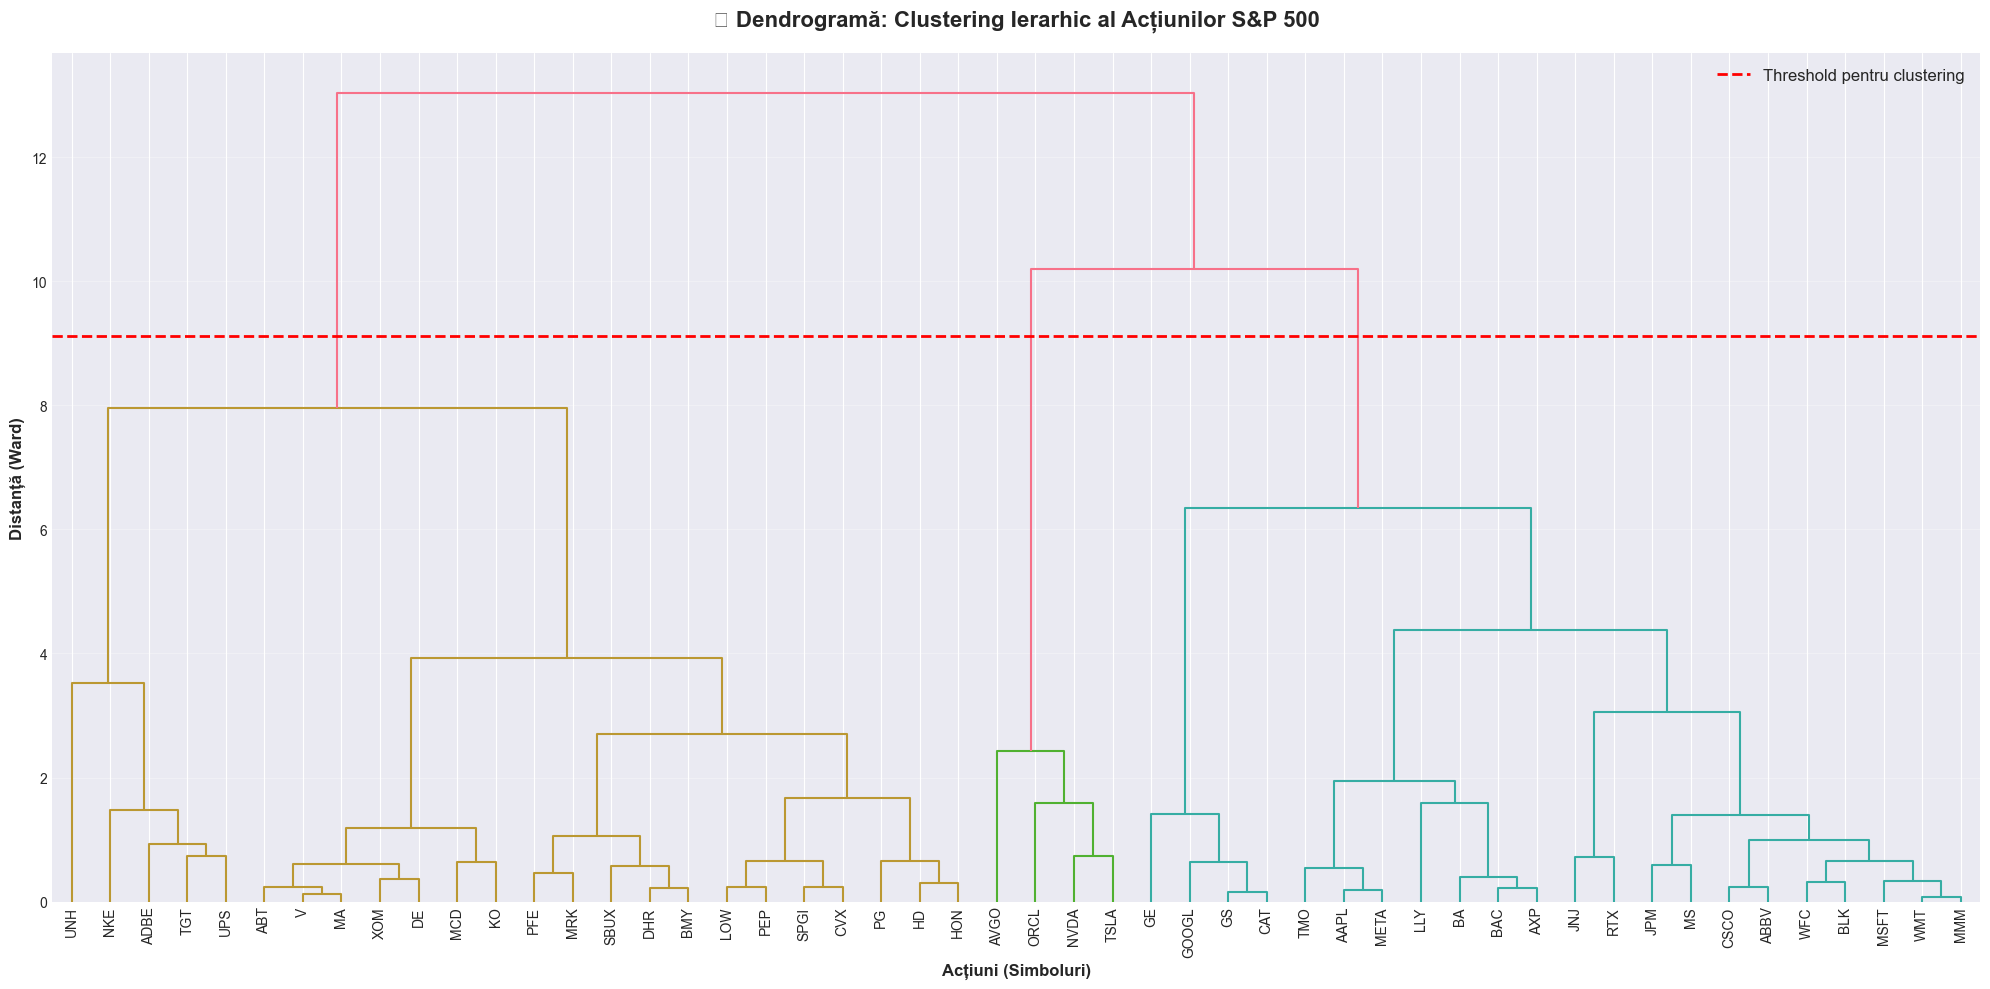


💡 Cum se citește dendrograma:
   1. Acțiunile de jos reprezintă fiecare companie
   2. Liniile verticale conectează acțiuni/clustere similare
   3. Înălțimea liniilor = distanța la care s-au combinat
   4. Linia roșie = threshold pentru a tăia dendrograma și a forma clustere
   5. Acțiuni conectate sub threshold = același cluster


In [14]:
# Aplicăm Clustering Ierarhic cu metoda Ward
print("🌳 Aplicare Clustering Ierarhic (Agglomerative cu Ward Linkage)\n")

# Calculăm matricea de legare (linkage matrix)
linkage_matrix = linkage(X_pca_2d, method='ward')

print("✅ Linkage matrix calculată!")
print(f"   - Metodă: Ward (minimizează varianța intra-cluster)")
print(f"   - Număr de merge-uri: {len(linkage_matrix)}")

# Vizualizare Dendrogramă
plt.figure(figsize=(20, 10))

dendrogram(
    linkage_matrix,
    labels=symbols,
    leaf_font_size=10,
    leaf_rotation=90,
    color_threshold=0.7*max(linkage_matrix[:,2])  # Colorare automată
)

plt.title('🌲 Dendrogramă: Clustering Ierarhic al Acțiunilor S&P 500', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Acțiuni (Simboluri)', fontsize=12, fontweight='bold')
plt.ylabel('Distanță (Ward)', fontsize=12, fontweight='bold')
plt.axhline(y=0.7*max(linkage_matrix[:,2]), color='red', linestyle='--', 
           linewidth=2, label='Threshold pentru clustering')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n💡 Cum se citește dendrograma:")
print("   1. Acțiunile de jos reprezintă fiecare companie")
print("   2. Liniile verticale conectează acțiuni/clustere similare")
print("   3. Înălțimea liniilor = distanța la care s-au combinat")
print("   4. Linia roșie = threshold pentru a tăia dendrograma și a forma clustere")
print("   5. Acțiuni conectate sub threshold = același cluster")

🎯 Clustering Ierarhic cu 9 clustere

📊 METRICI DE PERFORMANȚĂ:
   - Silhouette Score: 0.385
   - Davies-Bouldin Index: 0.630

📊 DISTRIBUȚIA ACȚIUNILOR ÎN CLUSTERE:

   Cluster 0: 4 acțiuni (8.0%)
   Cluster 1: 1 acțiuni (2.0%)
   Cluster 2: 7 acțiuni (14.0%)
   Cluster 3: 12 acțiuni (24.0%)
   Cluster 4: 4 acțiuni (8.0%)
   Cluster 5: 4 acțiuni (8.0%)
   Cluster 6: 7 acțiuni (14.0%)
   Cluster 7: 2 acțiuni (4.0%)
   Cluster 8: 9 acțiuni (18.0%)


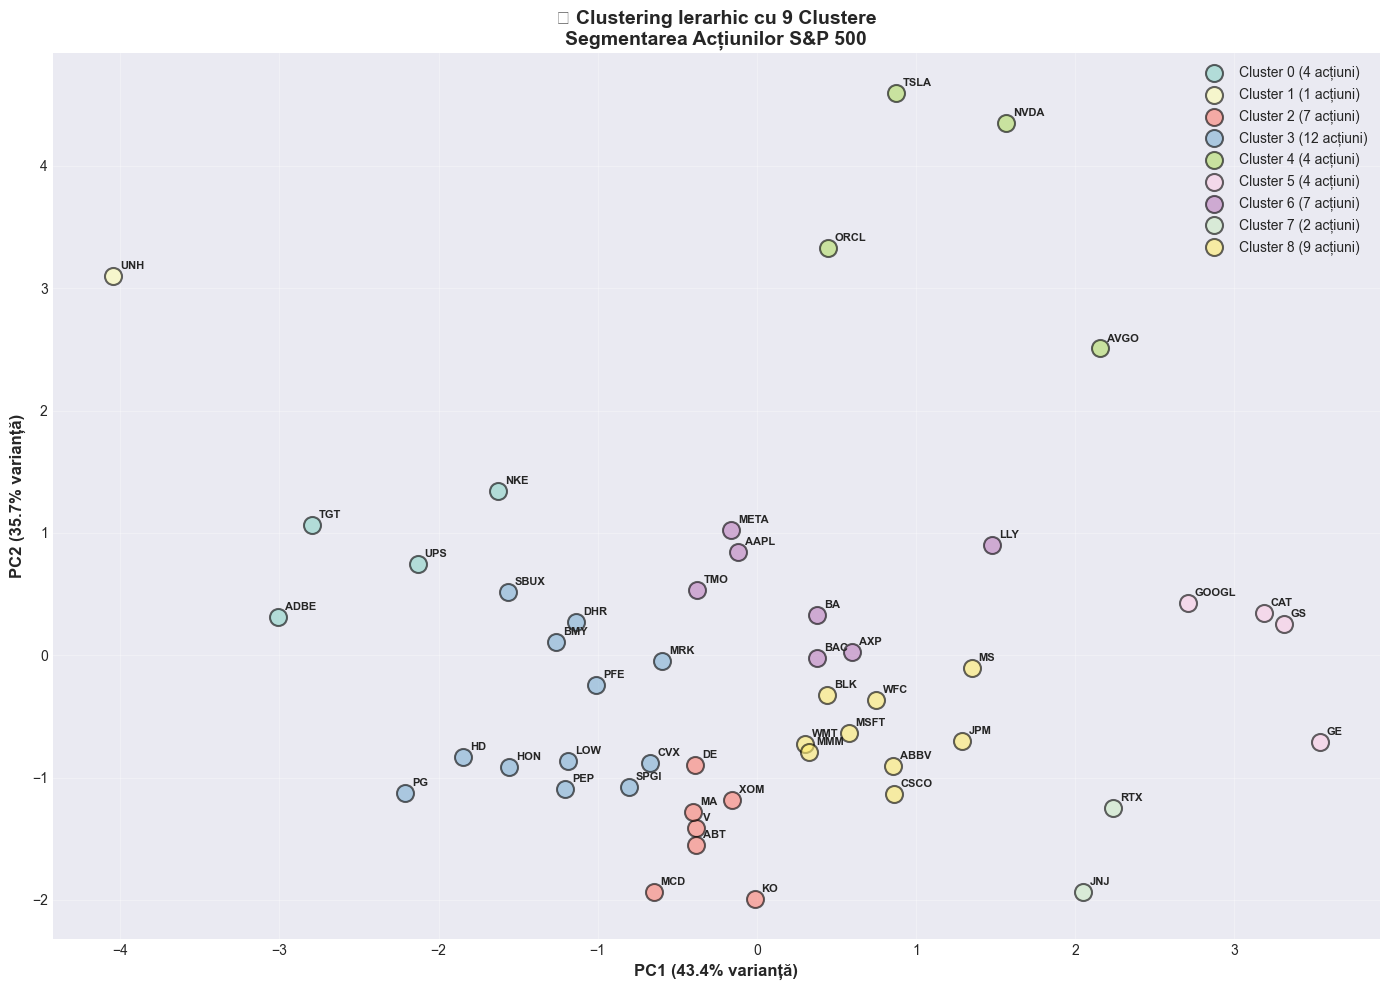

In [15]:
# Tăiem dendrograma pentru a crea același număr de clustere ca K-Means
hierarchical_labels = fcluster(linkage_matrix, optimal_k, criterion='maxclust')

# Ajustăm labelele să înceapă de la 0 (ca la K-Means)
hierarchical_labels = hierarchical_labels - 1

df_pca['Cluster_Hierarchical'] = hierarchical_labels
df_features['Cluster_Hierarchical'] = hierarchical_labels

# Calculăm metrici
hier_silhouette = silhouette_score(X_pca_2d, hierarchical_labels)
hier_davies_bouldin = davies_bouldin_score(X_pca_2d, hierarchical_labels)

print(f"🎯 Clustering Ierarhic cu {optimal_k} clustere\n")
print("="*70)
print(f"📊 METRICI DE PERFORMANȚĂ:")
print("="*70)
print(f"   - Silhouette Score: {hier_silhouette:.3f}")
print(f"   - Davies-Bouldin Index: {hier_davies_bouldin:.3f}")
print("="*70)

# Distribuția clusterelor
print(f"\n📊 DISTRIBUȚIA ACȚIUNILOR ÎN CLUSTERE:\n")
hier_cluster_counts = pd.Series(hierarchical_labels).value_counts().sort_index()
for cluster_id, count in hier_cluster_counts.items():
    print(f"   Cluster {cluster_id}: {count} acțiuni ({count/len(hierarchical_labels)*100:.1f}%)")

# Vizualizare clustere ierarhice
fig, ax = plt.subplots(figsize=(14, 10))

# Plot pentru fiecare cluster
for i in range(optimal_k):
    cluster_data = df_pca[df_pca['Cluster_Hierarchical'] == i]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], 
              s=150, alpha=0.6, c=[colors[i]], 
              edgecolors='black', linewidth=1.5,
              label=f'Cluster {i} ({len(cluster_data)} acțiuni)')
    
    # Adăugăm etichete
    for idx, row in cluster_data.iterrows():
        ax.annotate(row['Symbol'], 
                   (row['PC1'], row['PC2']),
                   fontsize=8, fontweight='bold',
                   xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}% varianță)', fontsize=12, fontweight='bold')
ax.set_title(f'🌳 Clustering Ierarhic cu {optimal_k} Clustere\nSegmentarea Acțiunilor S&P 500', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ⚖️ 9. Compararea K-Means vs. Clustering Ierarhic

### 🔍 Ce vom compara?

Vom analiza:
1. **Performanța** (Silhouette Score, Davies-Bouldin)
2. **Diferențele în atribuirea clusterelor**
3. **Stabilitatea** rezultatelor
4. **Interpretabilitatea** clusterelor

📊 COMPARAȚIE METRICI DE PERFORMANȚĂ

             Metodă  Silhouette Score  Davies-Bouldin Index
            K-Means            0.4331                0.5587
Clustering Ierarhic            0.3846                0.6304

🏆 Câștigător (Silhouette Score): K-Means
   Diferență: 0.048


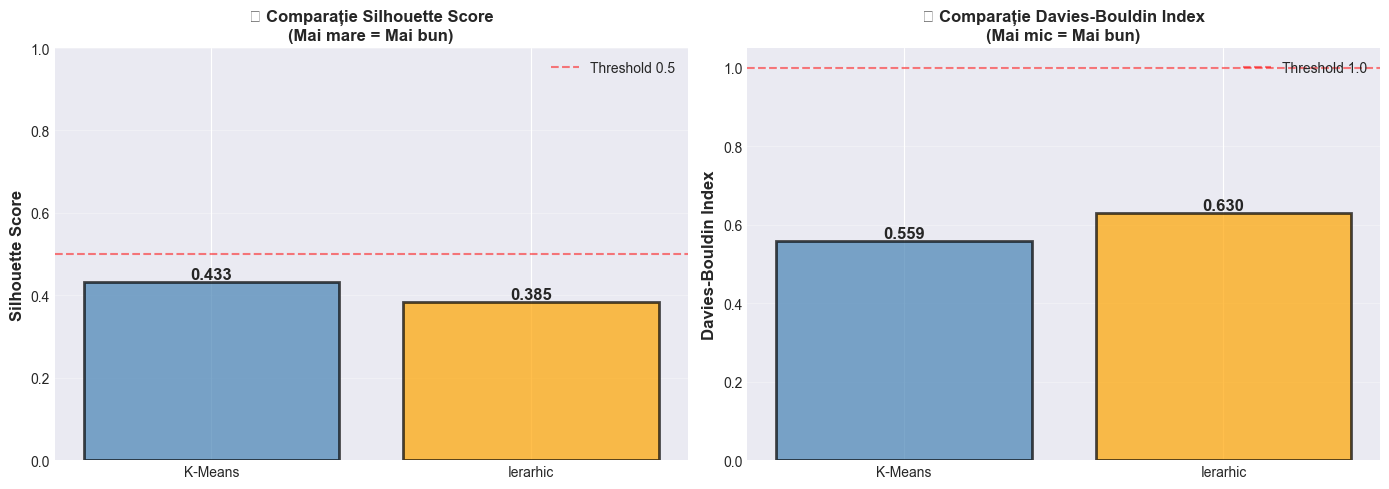

In [16]:
# Comparație metrici
comparison_df = pd.DataFrame({
    'Metodă': ['K-Means', 'Clustering Ierarhic'],
    'Silhouette Score': [final_silhouette, hier_silhouette],
    'Davies-Bouldin Index': [final_davies_bouldin, hier_davies_bouldin]
})

print("📊 COMPARAȚIE METRICI DE PERFORMANȚĂ\n")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Determinăm câștigătorul
if final_silhouette > hier_silhouette:
    winner = "K-Means"
    diff = final_silhouette - hier_silhouette
else:
    winner = "Clustering Ierarhic"
    diff = hier_silhouette - final_silhouette

print(f"\n🏆 Câștigător (Silhouette Score): {winner}")
print(f"   Diferență: {diff:.3f}")

# Vizualizare comparație
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafic 1: Silhouette Score
methods = ['K-Means', 'Ierarhic']
silhouette_values = [final_silhouette, hier_silhouette]
colors_bar = ['steelblue', 'orange']

bars1 = axes[0].bar(methods, silhouette_values, color=colors_bar, 
                    edgecolor='black', linewidth=2, alpha=0.7)
axes[0].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0].set_title('📊 Comparație Silhouette Score\n(Mai mare = Mai bun)', 
                 fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold 0.5')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# Adăugăm valori pe bare
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# Grafic 2: Davies-Bouldin Index
davies_values = [final_davies_bouldin, hier_davies_bouldin]

bars2 = axes[1].bar(methods, davies_values, color=colors_bar, 
                    edgecolor='black', linewidth=2, alpha=0.7)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[1].set_title('📈 Comparație Davies-Bouldin Index\n(Mai mic = Mai bun)', 
                 fontsize=12, fontweight='bold')
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Threshold 1.0')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

# Adăugăm valori pe bare
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

🔍 ANALIZA CONCORDANȚEI ÎNTRE METODE

Adjusted Rand Index (ARI): 0.577

💡 Interpretare ARI:
   - ARI = 1.0: Clustering identic
   - ARI = 0.0: Clustering aleatoriu
   - ARI < 0.0: Clustering mai prost decât aleatoriu


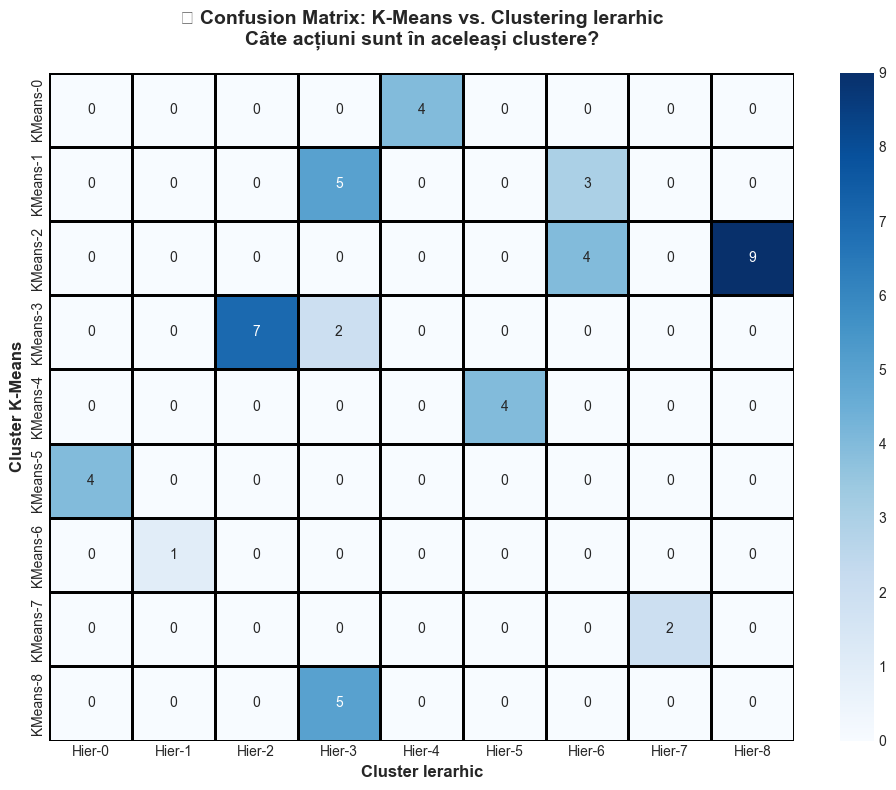


💡 Interpretare Confusion Matrix:
   - Diagonala = acțiuni clasificate în același cluster de ambele metode
   - Off-diagonal = acțiuni clasificate diferit
   - Valori mari pe diagonală = concordanță mare între metode


In [17]:
# Analizăm diferențele în atribuirea clusterelor
from sklearn.metrics import confusion_matrix, adjusted_rand_score

# Calculăm Adjusted Rand Index (măsoară similaritatea între două clusterings)
ari = adjusted_rand_score(df_features['Cluster_KMeans'], df_features['Cluster_Hierarchical'])

print(f"🔍 ANALIZA CONCORDANȚEI ÎNTRE METODE\n")
print("="*70)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print("\n💡 Interpretare ARI:")
print("   - ARI = 1.0: Clustering identic")
print("   - ARI = 0.0: Clustering aleatoriu")
print("   - ARI < 0.0: Clustering mai prost decât aleatoriu")
print("="*70)

# Confusion Matrix
cm = confusion_matrix(df_features['Cluster_KMeans'], df_features['Cluster_Hierarchical'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           linewidths=1, linecolor='black',
           xticklabels=[f'Hier-{i}' for i in range(optimal_k)],
           yticklabels=[f'KMeans-{i}' for i in range(optimal_k)])
plt.title('🔥 Confusion Matrix: K-Means vs. Clustering Ierarhic\nCâte acțiuni sunt în aceleași clustere?', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster Ierarhic', fontsize=12, fontweight='bold')
plt.ylabel('Cluster K-Means', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretare Confusion Matrix:")
print("   - Diagonala = acțiuni clasificate în același cluster de ambele metode")
print("   - Off-diagonal = acțiuni clasificate diferit")
print("   - Valori mari pe diagonală = concordanță mare între metode")

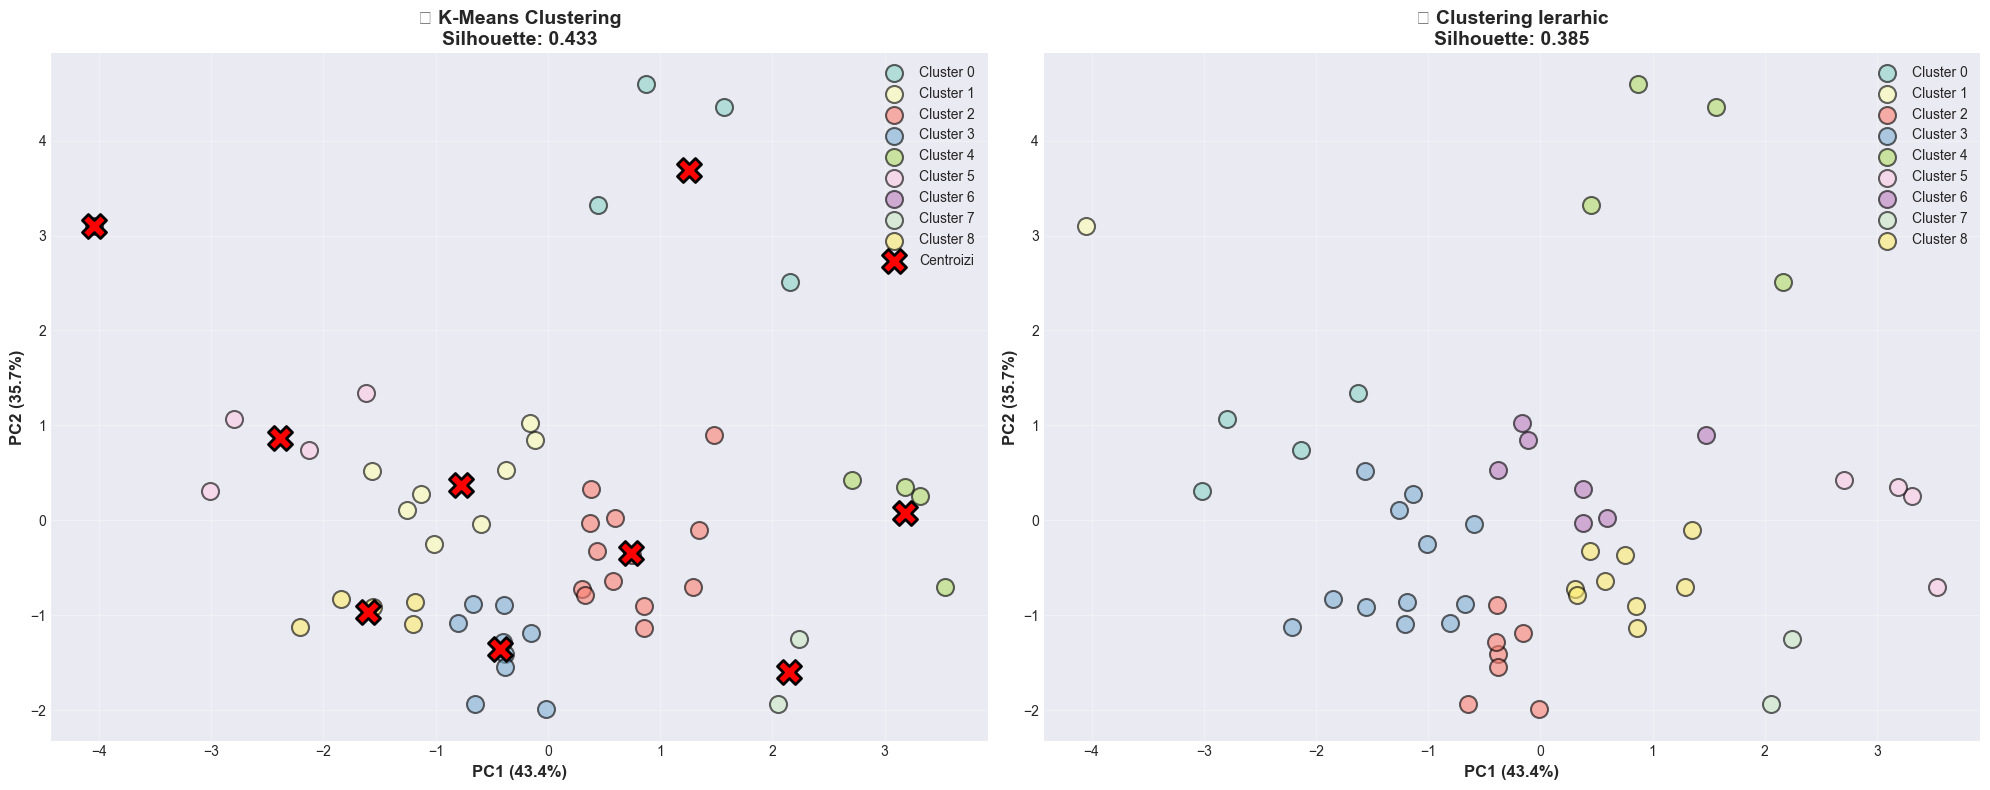

In [18]:
# Vizualizare side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# K-Means
for i in range(optimal_k):
    cluster_data = df_pca[df_pca['Cluster_KMeans'] == i]
    axes[0].scatter(cluster_data['PC1'], cluster_data['PC2'], 
                   s=150, alpha=0.6, c=[colors[i]], 
                   edgecolors='black', linewidth=1.5,
                   label=f'Cluster {i}')

axes[0].scatter(centroids[:, 0], centroids[:, 1], 
               s=300, c='red', marker='X', 
               edgecolors='black', linewidth=2,
               label='Centroizi', zorder=5)

axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12, fontweight='bold')
axes[0].set_title(f'🎯 K-Means Clustering\nSilhouette: {final_silhouette:.3f}', 
                 fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Clustering Ierarhic
for i in range(optimal_k):
    cluster_data = df_pca[df_pca['Cluster_Hierarchical'] == i]
    axes[1].scatter(cluster_data['PC1'], cluster_data['PC2'], 
                   s=150, alpha=0.6, c=[colors[i]], 
                   edgecolors='black', linewidth=1.5,
                   label=f'Cluster {i}')

axes[1].set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12, fontweight='bold')
axes[1].set_title(f'🌳 Clustering Ierarhic\nSilhouette: {hier_silhouette:.3f}', 
                 fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Exportăm rezultatele finale
final_results = df_features[['Symbol', 'Total_Return_%', 'Volatility_%', 
                            'Sharpe_Ratio', 'Cluster_KMeans', 'Cluster_Hierarchical']].copy()

# Sortăm după cluster K-Means
final_results = final_results.sort_values(['Cluster_KMeans', 'Total_Return_%'], ascending=[True, False])

print("📊 REZULTATE FINALE - TOP ACȚIUNI PER CLUSTER (K-Means)\n")
print("="*90)

for cluster_id in range(optimal_k):
    print(f"\n🎯 CLUSTER {cluster_id}:")
    cluster_data = final_results[final_results['Cluster_KMeans'] == cluster_id]
    print(cluster_data.to_string(index=False))
    print("="*90)

print("\n✅ Analiză completă! Notebook executat cu succes!")
print("\n📥 Pentru a salva rezultatele, poți exporta dataframe-ul:")
print("   final_results.to_csv('clustering_results.csv', index=False)")

📊 REZULTATE FINALE - TOP ACȚIUNI PER CLUSTER (K-Means)


🎯 CLUSTER 0:
Symbol  Total_Return_%  Volatility_%  Sharpe_Ratio  Cluster_KMeans  Cluster_Hierarchical
  AVGO         51.4163       53.1594        1.0179               0                     4
  NVDA         36.5315       49.6337        0.8434               0                     4
  TSLA         19.8936       63.2964        0.5717               0                     4
  ORCL         19.5810       61.8072        0.5496               0                     4

🎯 CLUSTER 1:
Symbol  Total_Return_%  Volatility_%  Sharpe_Ratio  Cluster_KMeans  Cluster_Hierarchical
  AAPL         12.3080       32.4608        0.4599               1                     6
   TMO         11.8548       32.3020        0.4479               1                     6
  META         10.8651       38.0197        0.4097               1                     6
   MRK         10.4870       30.3929        0.4181               1                     3
   DHR          0.7333    